In [ ]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy as v2n
from vtk.util.numpy_support import numpy_to_vtk as n2v
import numpy as np
from pathlib import Path
import subprocess
from pathlib import Path
import xml.etree.ElementTree as ET

def parse_mdl(mdl_file: str, reverse = False):
    """parses mdl file for cap name mapping to faceid

    Args:
        mdl_file (str): path to mdl file
        reverse (bool, optional): reverses mapping so faceid maps to cap name. Defaults to False.

    Returns:
        dict: a dict describing map of cap name to faceid
    """
    
    # since .mdl has a line like "<format version="1.0" />" which fails for the standard XMLparser, rather than creating a custom parser, just remove that line after reading the file in and parse as a list of strings
    mdl_file = str(mdl_file)
    with open(mdl_file, 'r') as mdl:
        lines = mdl.readlines()
        if 'format' in lines[1]:
            lines[1] = ''
    
    root = ET.fromstringlist(lines)
    faces = root[0][0].find('faces')

    # save to a dict
    face_mappings = {}
    for face in faces:
        if face.attrib['type'] == 'cap':
            if reverse:
                face_mappings[int(face.attrib['id'])] = face.attrib['name']
            else:
                face_mappings[face.attrib['name']] = int(face.attrib['id'])
    return face_mappings



class Polydata():
    """Base Polydata Class
    """
    def __init__(self, polydata = None):
        self.polydata = polydata
    
    def convert_from_parasolid(self, parasolid_file):
        '''loads a Parasolid xmt_txt file which is converted into polydata.
        Only accessible throught a private Parasolid plugin.
        '''
        #! Currently not working as intended. Please use Simvascular's GUI to perform this operation.
        raise NotImplementedError("Currently not working as intended. Please use Simvascular's GUI to perform this operation. ")
        
        try:
            import sv
        except ImportError as e:
            print(e + ': use simvascular --python -- this_script.py')
            exit(1)
        
        try:
            kernel = sv.modeling.Kernel.PARASOLID
            modeler = sv.modeling.Modeler(kernel)

            # Read model geometry.
            model = modeler.read(parasolid_file)
            self.polydata = model.get_polydata()
        except Exception as e:
            print(e, ': requires parasolid plugin, which is a private plugin.')
    
    @classmethod
    def load_polydata(cls, input_file, format = 'xml'):
        '''loads a PolyData file from <input_file> which is in <format>
        
        format: (str) One of 'xml', NULL
        '''
        
        if format == 'xml':
            reader = vtk.vtkXMLPolyDataReader()
            reader.SetFileName(input_file)
            reader.Update()
            return cls(reader.GetOutput())
        
    def read_polydata(self, input_file):
        reader = vtk.vtkXMLPolyDataReader()
        reader.SetFileName(input_file)
        reader.Update()
        self.polydata = reader.GetOutput()
    
    @classmethod
    def create_new(cls):
        """Creates a new polydata
        """
        return cls(vtk.vtkPolyData())

    def write_polydata(self, output_file, format = 'xml'):
        ''' writes the polydata information to <output_file> in <format>
        
        format: (str) One of 'xml', NULL
        '''
        
        if format == 'xml':
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(output_file)
            writer.SetInputData(self.polydata)
            writer.Update()
            writer.Write()

    def get_pointdata(self):
        ''' get pointdata object
        '''
        return self.polydata.GetPointData()
    
    def get_celldata(self):
        ''' get celldata object
        '''
        return self.polydata.GetCellData()

    def get_points(self):
        ''' retrieve xyz points
        '''
        return v2n(self.polydata.GetPoints().GetData())    
    
    def get_pointdata_array(self, array_name):
        ''' retrieve array data from Point Data
        '''
        return v2n(self.polydata.GetPointData().GetArray(array_name))
    
    def get_celldata_array(self, array_name):
        ''' retrieves array data from Cell Data
        '''
        return v2n(self.polydata.GetCellData().GetArray(array_name))
    
    def get_pointdata_arraynames(self):
        ''' get pointdata array names
        '''
        pointdata = self.get_pointdata()
        array_num = pointdata.GetNumberOfArrays()
        array_names = [pointdata.GetArrayName(i) for i in range(array_num)]
        return array_names
    
    def add_pointdata(self, array: np.array, array_name):
        ''' Adds a new array to point data.
        Use this to overwrite old arrays or add new arrays. To overwrite, simply provide the old array's array name.
        '''
        new_celldata = n2v(array)
        new_celldata.SetName(array_name)
        self.polydata.GetPointData().AddArray(new_celldata)
       
    def remove_pointdata_array(self, array_name):
        ''' removes an array from pointdata
        '''
        self.polydata.GetPointData().RemoveArray(array_name)

    def rename_pointdata_array(self, old_name, new_name):
        ''' Rename point data array
        '''
        tmp = self.polydata.GetPointData().GetArray(old_name)
        tmp.SetName(new_name)
    

class Centerlines(Polydata):
    ''' Handles centerlines
    '''
    
    class CellDataFields(object):
        pass

    class PointDataFields(object):
        """ This class defines the standard used field point data field names.
        """
        AREA = "CenterlineSectionArea"
        CENTID = "CenterlineId"
        PATH = "Path"
        BRANCHID = "BranchId"
        BIFURCATIONID = "BifurcationId"
        NODEID = "GlobalNodeId"
        NORMAL = "CenterlineSectionNormal"
        
    def __init__(self, centerlines = None):
        super().__init__(centerlines)
        self.centerlines = self.polydata

    @classmethod
    def load_centerlines(cls, centerlines_file):
        return cls.load_polydata(centerlines_file)
        
    def check_centerlines_data(self):
        """ Check that the centerline data contains all of the required fields.
        """
        field_names = [v for k, v in self.CellDataFields.__dict__.items() if not k.startswith('__')]
        for field in field_names:
            if not self.polydata.GetCellData().GetArray(field):
                print("Centerlines do not contain the '%s' data field." % field)
                return False

        field_names = [v for k, v in self.PointDataFields.__dict__.items() if not k.startswith('__')]
        for field in field_names:
            if not self.polydata.GetPointData().GetArray(field):
                print("Centerlines do not contain the '%s' data field." % field)
                return False
        return True

    
    def generate_centerlines(self, mdl, vtp, inlet, outfile):
        ''' Generates centerlines by creating a subprocess and calling sv.
        
        mdl:    (str) file path to the .mdl file
        vtp:    (vtp) file path to the model .vtp file
        
             
        '''
        
                
        # parse mdl for mapping
        face_mappings = parse_mdl(mdl)

        # get face ids.
        inlet_ids = [face_mappings[inlet]]
        del face_mappings[inlet]
        ordered_outlets = sorted(list(face_mappings.keys()))
        outlet_ids = [face_mappings[key] for key in ordered_outlets] #! there is an unavoidable ordering bug, so this fixes it.
        
        
        try:
            x = subprocess.run(["simvascular", "--python", "--",  str(Path(__file__).parent / "svScripts" / "sv_centerline_gen.py"), vtp, str(inlet_ids[0]), '|'.join([str(idx) for idx in outlet_ids]), outfile])
            if x.returncode!= 0:
                raise Exception("Centerlines could not be generated.")
        except FileNotFoundError:
            print("Simvascular is likely not installed on your machine.")
        
        self.polydata = self.read_polydata(outfile)
        
        return ordered_outlets
        

In [71]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from svinterface.plotting.params import set_params


    
def plot_valid(c_3d: Centerlines, c_1d_list: list):
    
    # use valid array
    caps = c_3d.get_pointdata_array("Caps_0D")
    juncs = c_3d.get_pointdata_array("Junctions_0D") 
    vess = c_3d.get_pointdata_array("Vessels_0D") 
    #! pull out which outlet it actually is
    valid = np.array(sorted(list(set([0] + list(np.where(caps != -1)[0]) + list(np.where(juncs != -1)[0]) + list(np.where(vess != -1)[0])))))
    
    results_3d = {}
    # iterate through each valid point
    for oidx, point_id in enumerate(valid):
        time = []
        pressure = []
        flow = []
        #! use the fact that they should be in order already
        for arr_name in c_3d.get_pointdata_arraynames():
            if arr_name.startswith("pressure_"):
                time.append(float(arr_name.split('_')[1]))
                pressure.append(c_3d.polydata.GetPointData().GetArray(arr_name).GetValue(point_id))
        
        results_3d[oidx] = {'time': time,
                            'pressure': pressure,
                            'flow': flow,
                            'point_id': point_id}
    
    fig1, ax1 = plt.subplots(1, 3, figsize=(26, 8), )
    fig2, ax2 = plt.subplots(1, 3, figsize=(26, 8))
    fig1.suptitle("Summary Comparison of 0D and 3D Values at Relevant Points")
    s = 30
    threed_means = []
    for i in range(len(valid)):
        threed_means.append(np.trapz(results_3d[i]['pressure'], results_3d[i]['time']) / (results_3d[i]['time'][-1] - results_3d[i]['time'][0]))
    ax1[1].scatter(range(len(valid)), threed_means, s =s, color = "black", marker='^', label = '3D')
    ax1[1].set_title("Mean")
    ax1[1].set_ylabel("Pressure (mmHg)")
    ax1[1].set_xlabel("Points")
    
    threed_maxs = []
    for i in range(len(valid)):
        threed_maxs.append(np.array(results_3d[i]['pressure']).max())
    ax1[0].scatter(range(len(valid)), threed_maxs, s =s,color = "black", marker='^',label = '3D')

    ax1[0].set_title("Systolic")
    ax1[0].set_ylabel("Pressure (mmHg)")
    ax1[0].set_xlabel("Points")
    
    threed_mins = []
    for i in range(len(valid)):
        threed_mins.append(np.array(results_3d[i]['pressure']).min())
    ax1[2].scatter(range(len(valid)), threed_mins,s =s,color = "black", marker='^', label = '3d')
    ax1[2].set_title("Diastolic")
    ax1[2].set_ylabel("Pressure (mmHg)")
    ax1[2].set_xlabel("Points")

    
    fig2.suptitle("3D vs 0D Pressures at Relevant Points.")
    ax2[0].plot([min(threed_maxs), max(threed_maxs)], [min(threed_maxs), max(threed_maxs)], 'black')
    ax2[0].set_title("Systolic")
    ax2[1].plot([min(threed_means), max(threed_means)], [min(threed_means), max(threed_means)], 'black')
    ax2[1].set_title("Mean")
    ax2[2].plot([min(threed_mins), max(threed_mins)], [min(threed_mins), max(threed_mins)], 'black')
    ax2[2].set_title("Diastolic")
    for i in range(3):
        ax2[i].set_ylabel("0D Pressure (mmHg)")
        ax2[i].set_xlabel("3D Pressure (mmHg)")
    
    
    np.save("3d_data.npy", {'3d_mins':threed_mins,
             '3d_maxs':threed_maxs,
             '3d_means':threed_means})
    
    x = {}
    
    for c_1d, name in c_1d_list:
        results_1d = {}
        # iterate through each outlet
        for oidx, point_id in enumerate(valid):
            time = []
            pressure = []
            flow = []
            #! use the fact that they should be in order already
            for arr_name in c_1d.get_pointdata_arraynames():
                if arr_name.startswith("pressure_"):
                    time.append(float(arr_name.split('_')[1]))
                    pressure.append(c_1d.polydata.GetPointData().GetArray(arr_name).GetValue(point_id))
            
            results_1d[oidx] = {'time': time,
                                'pressure': pressure,
                                'flow': flow,
                                'point_id': point_id}
        
        ## Summary Statistics
        
        ## means
 
        zerod_means = []
        for i in range(len(valid)):
            zerod_means.append(np.trapz(results_1d[i]['pressure'], results_1d[i]['time']) / (results_1d[i]['time'][-1] - results_1d[i]['time'][0]))
        ax1[1].scatter(range(len(valid)), zerod_means,s =s, label = name, alpha = .7)
        
        ## systolic
        zerod_maxs = []
        for i in range(len(valid)):
            zerod_maxs.append(np.array(results_1d[i]['pressure']).max())
        ax1[0].scatter(range(len(valid)), zerod_maxs, s =s,label = name, alpha = .7)
        
        # diastolic
        zerod_mins = []
        for i in range(len(valid)):
            zerod_mins.append(np.array(results_1d[i]['pressure']).min())
        ax1[2].scatter(range(len(valid)), zerod_mins,s =s, label = name, alpha = .7)
        
        ## plot 3D on x axis, and 0D on y axis
        ax2[0].scatter(threed_maxs, zerod_maxs,s =s, label = name, alpha = .7)
        ax2[1].scatter(threed_means, zerod_means,s =s, label = name, alpha = .7)
        ax2[2].scatter(threed_mins, zerod_mins, s =s,label = name, alpha = .7)

        x[name] = {'0d_mins':zerod_mins,
                '0d_maxs':zerod_maxs,
                '0d_means':zerod_means}
    np.save('0d_data.npy', x)
        


    handles, labels = ax1[0].get_legend_handles_labels()
    fig1.legend(handles, labels, loc='upper right')
    handles, labels = ax2[0].get_legend_handles_labels()
    fig2.legend(handles, labels, loc='upper right')
    
    return fig1, fig2

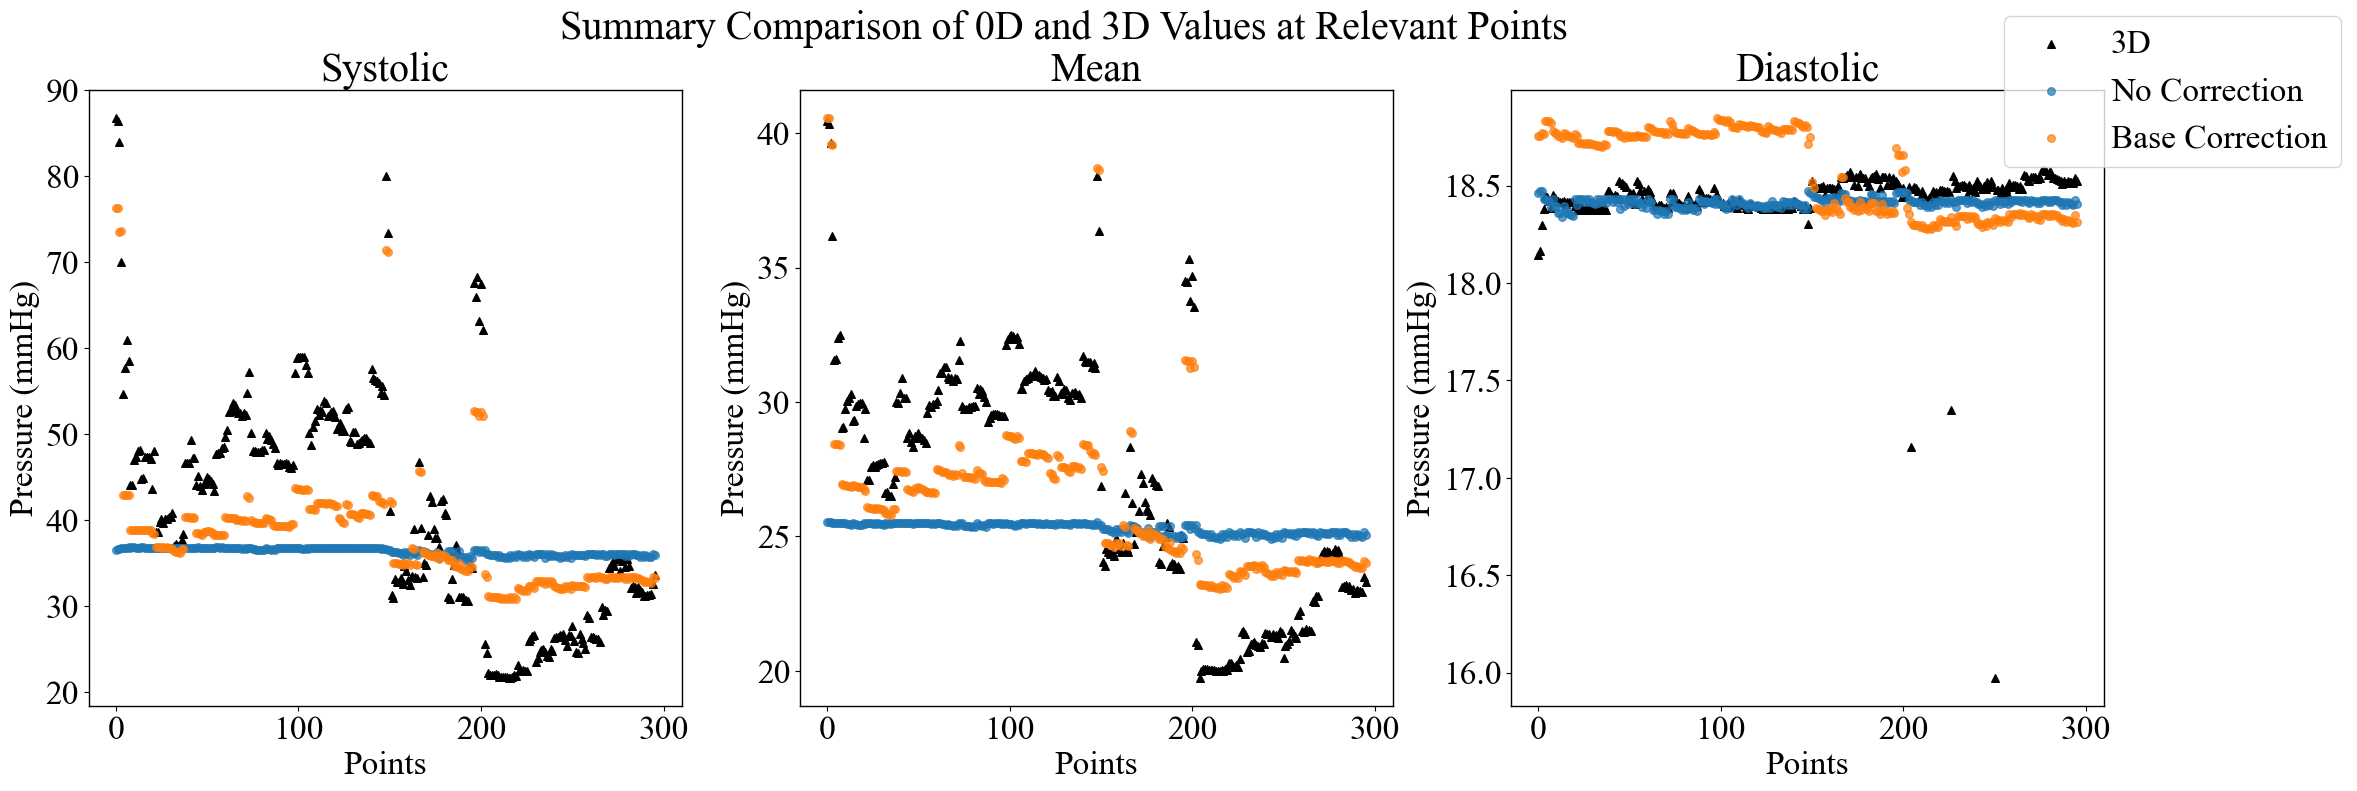

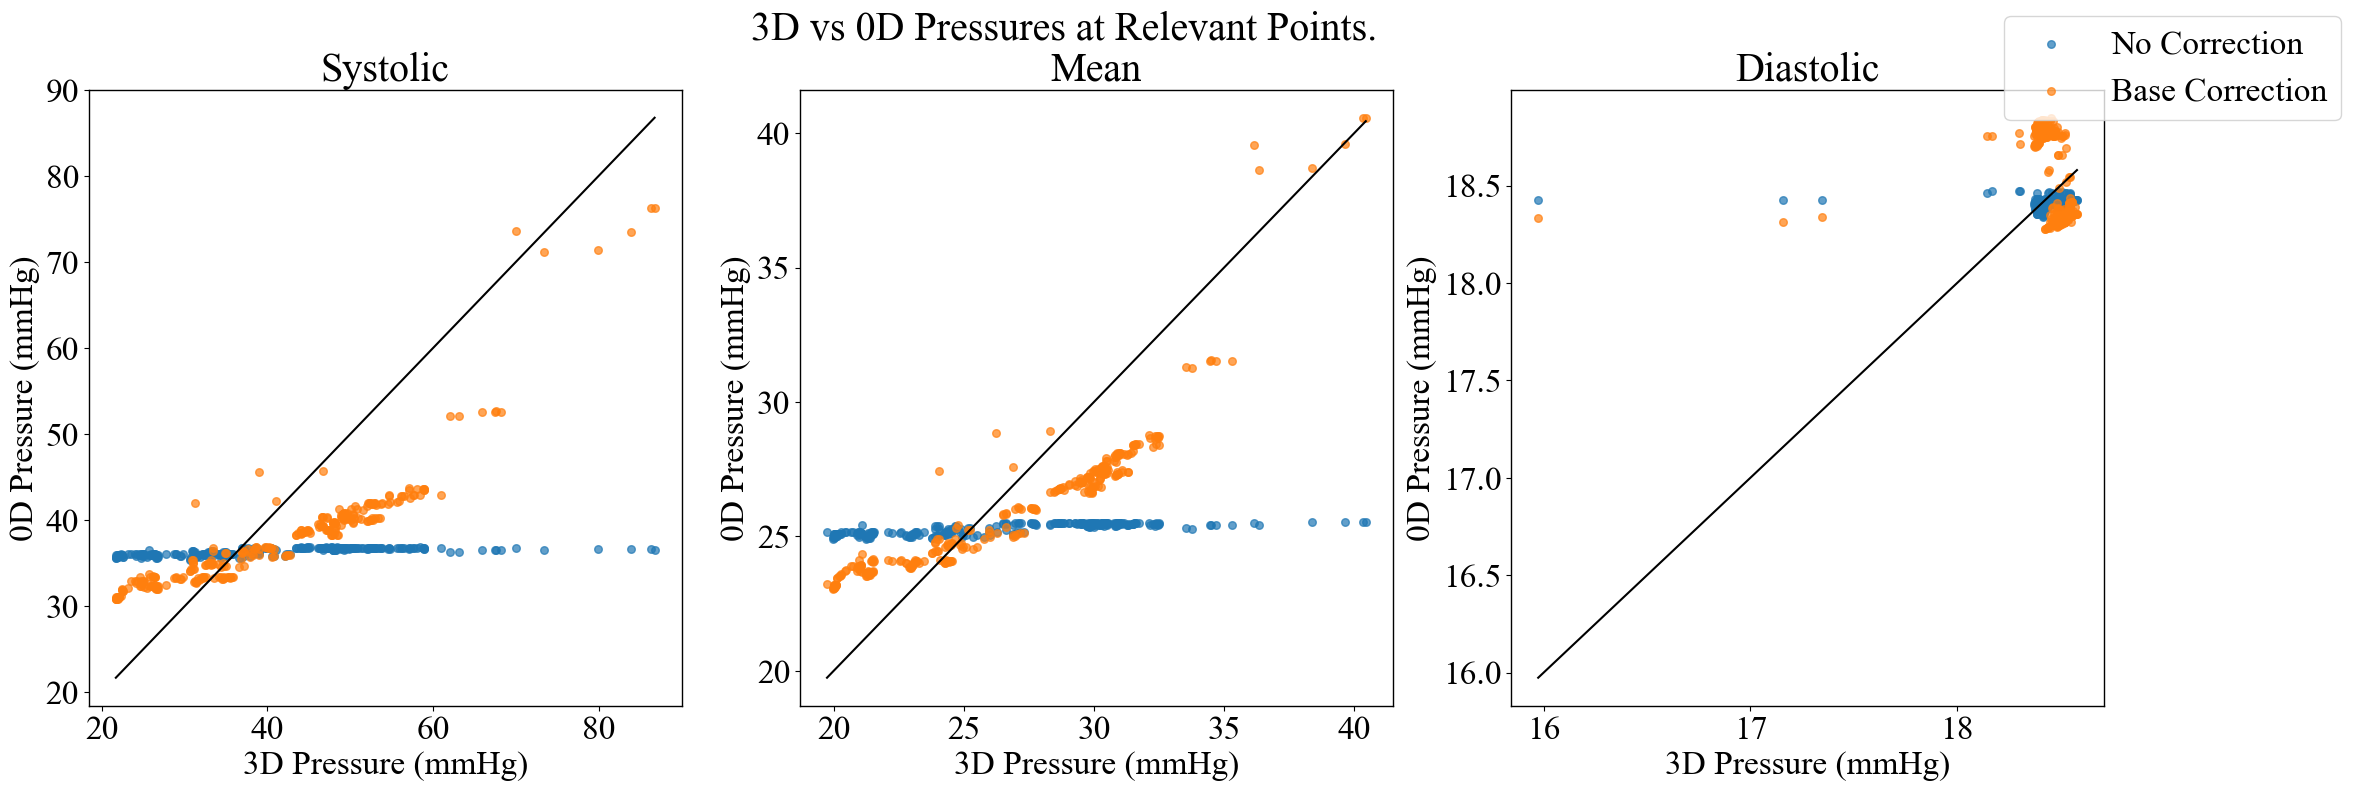

In [72]:
c_3d = Centerlines.load_polydata('../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/3D_DIR/prestent/AS1_SU0308_3D_centerlines.formatted.vtp')
    
c_0d = [(Centerlines.load_centerlines('../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/LPN_DIR/AS1_SU0308.sim.0/centerline_projection.vtp'), "No Correction"), (Centerlines.load_centerlines('../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/LPN_DIR/AS1_SU0308.sim.1/centerline_projection.vtp'), "Base Correction")]

# plotting params
set_params(size=24)

fig1, fig2 = plot_valid(c_3d, c_0d)

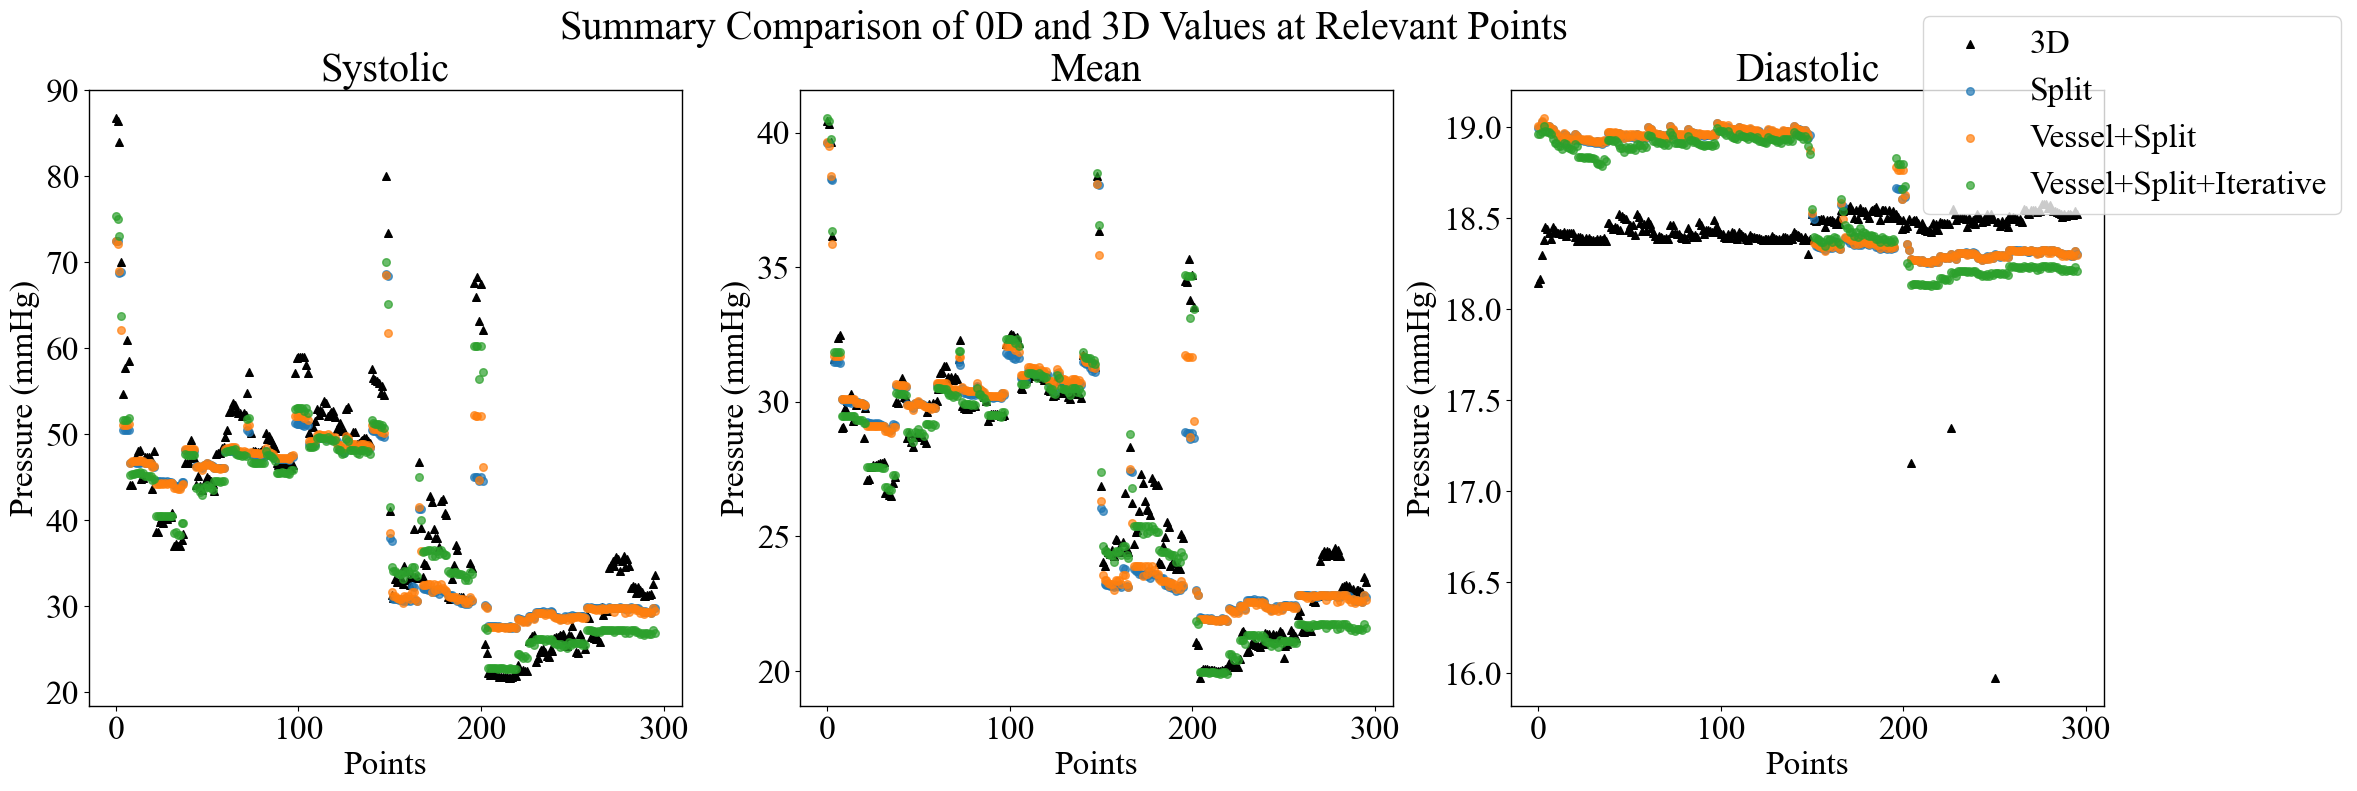

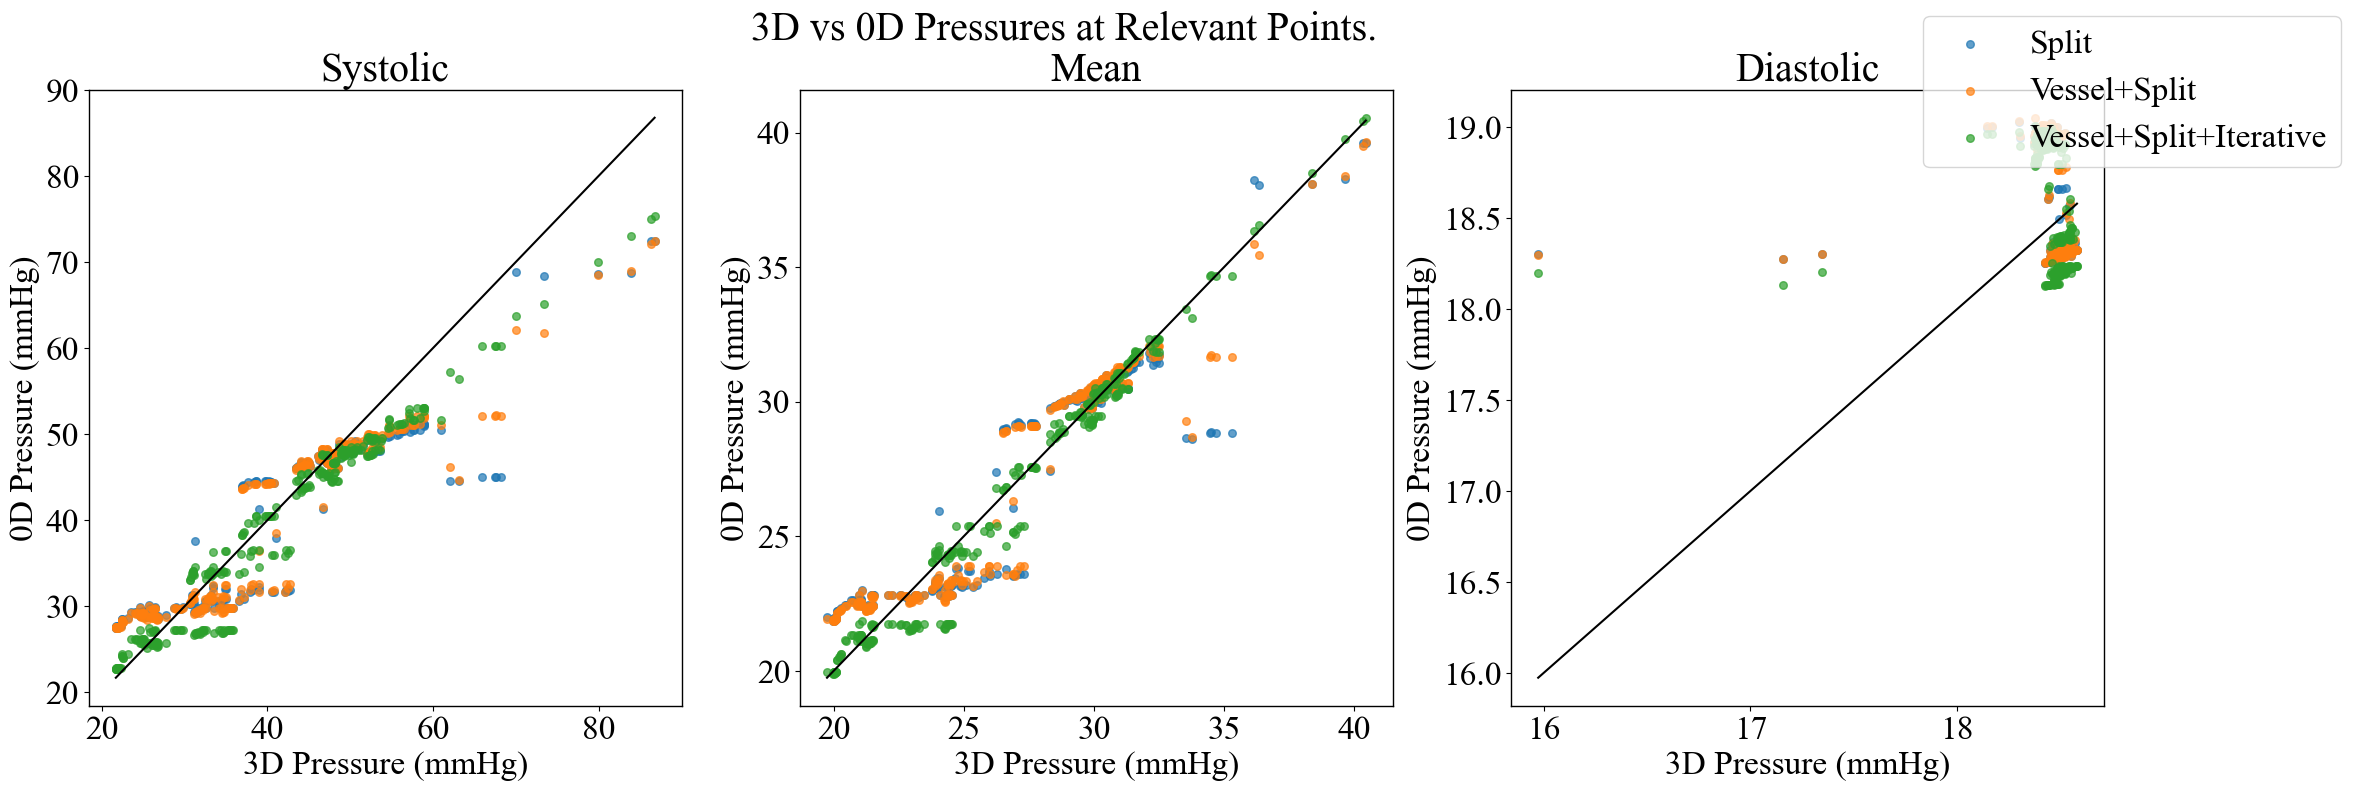

In [73]:
c_3d = Centerlines.load_polydata('../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/3D_DIR/prestent/AS1_SU0308_3D_centerlines.formatted.vtp')
    
c_0d = [(Centerlines.load_centerlines('../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/LPN_DIR/AS1_SU0308.sim.2/centerline_projection.vtp'), "Split"), (Centerlines.load_centerlines('../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/LPN_DIR/AS1_SU0308.sim.4/centerline_projection.vtp'), "Vessel+Split"), (Centerlines.load_centerlines('../../data/diseased/AS1_SU0308_stent/results/AS1_SU0308_nonlinear/LPN_DIR/AS1_SU0308.sim.5/centerline_projection.vtp'), "Vessel+Split+Iterative")]

# plotting params
set_params(size=24)

fig1, fig2 = plot_valid(c_3d, c_0d)

{'3d_mins': [18.143685221476957, 18.166654960595995, 18.2993674205547, 18.377801989361032, 18.44912274486346, 18.44171937688868, 18.420745545951736, 18.384466502184384, 18.45066823025574, 18.435651065234197, 18.426700095827297, 18.419952415882104, 18.417672095826198, 18.415302805807993, 18.422618710151152, 18.40431408868108, 18.41820434202816, 18.417676275265386, 18.417484696986783, 18.416787189755524, 18.39678238918093, 18.37332070322322, 18.398714023732765, 18.398171468163433, 18.389568757845165, 18.377354325875594, 18.389125470687183, 18.37514617446463, 18.390555432179717, 18.380856796756152, 18.379661531236874, 18.375172012996796, 18.38561206086096, 18.37458064417176, 18.38513549555847, 18.377624810530378, 18.393225640682168, 18.37568113872497, 18.472843817083056, 18.47197639722851, 18.45326797764965, 18.443328492217987, 18.45372734675799, 18.445108079326115, 18.522165980222855, 18.43399239273591, 18.513587529605683, 18.501067845504654, 18.493826620613895, 18.43562723227942, 18.462

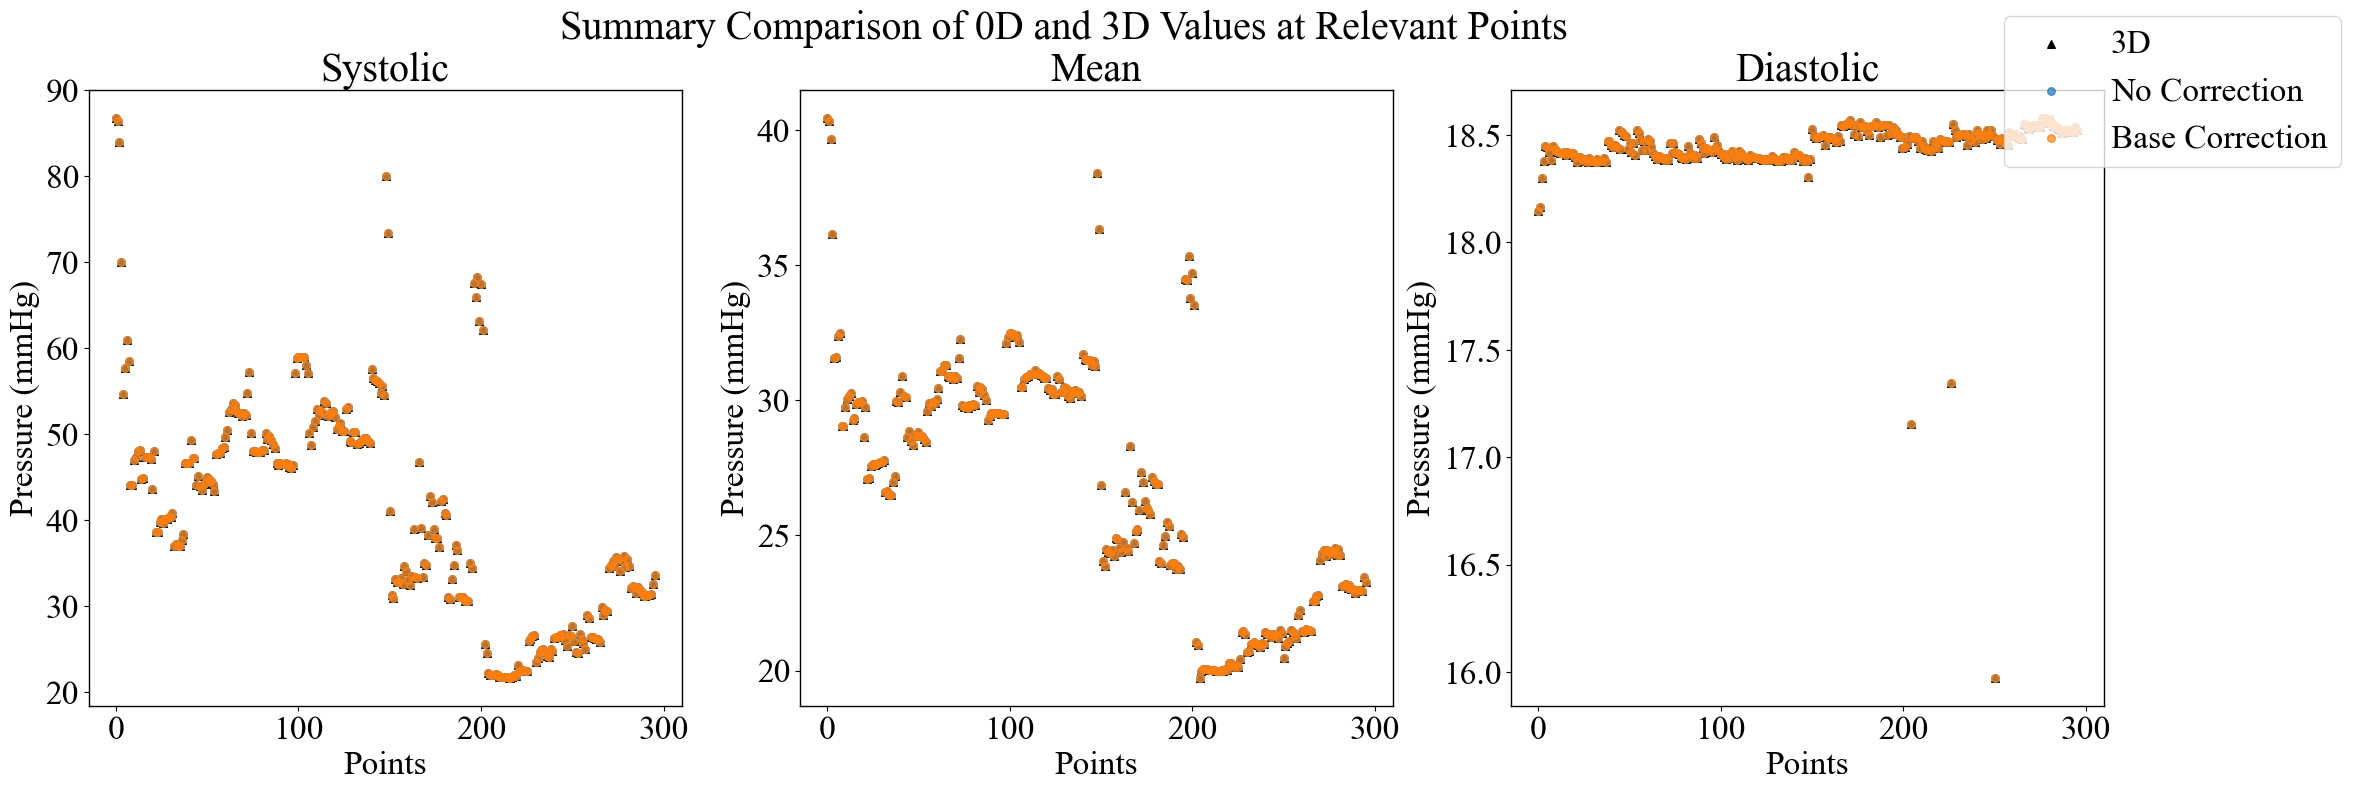

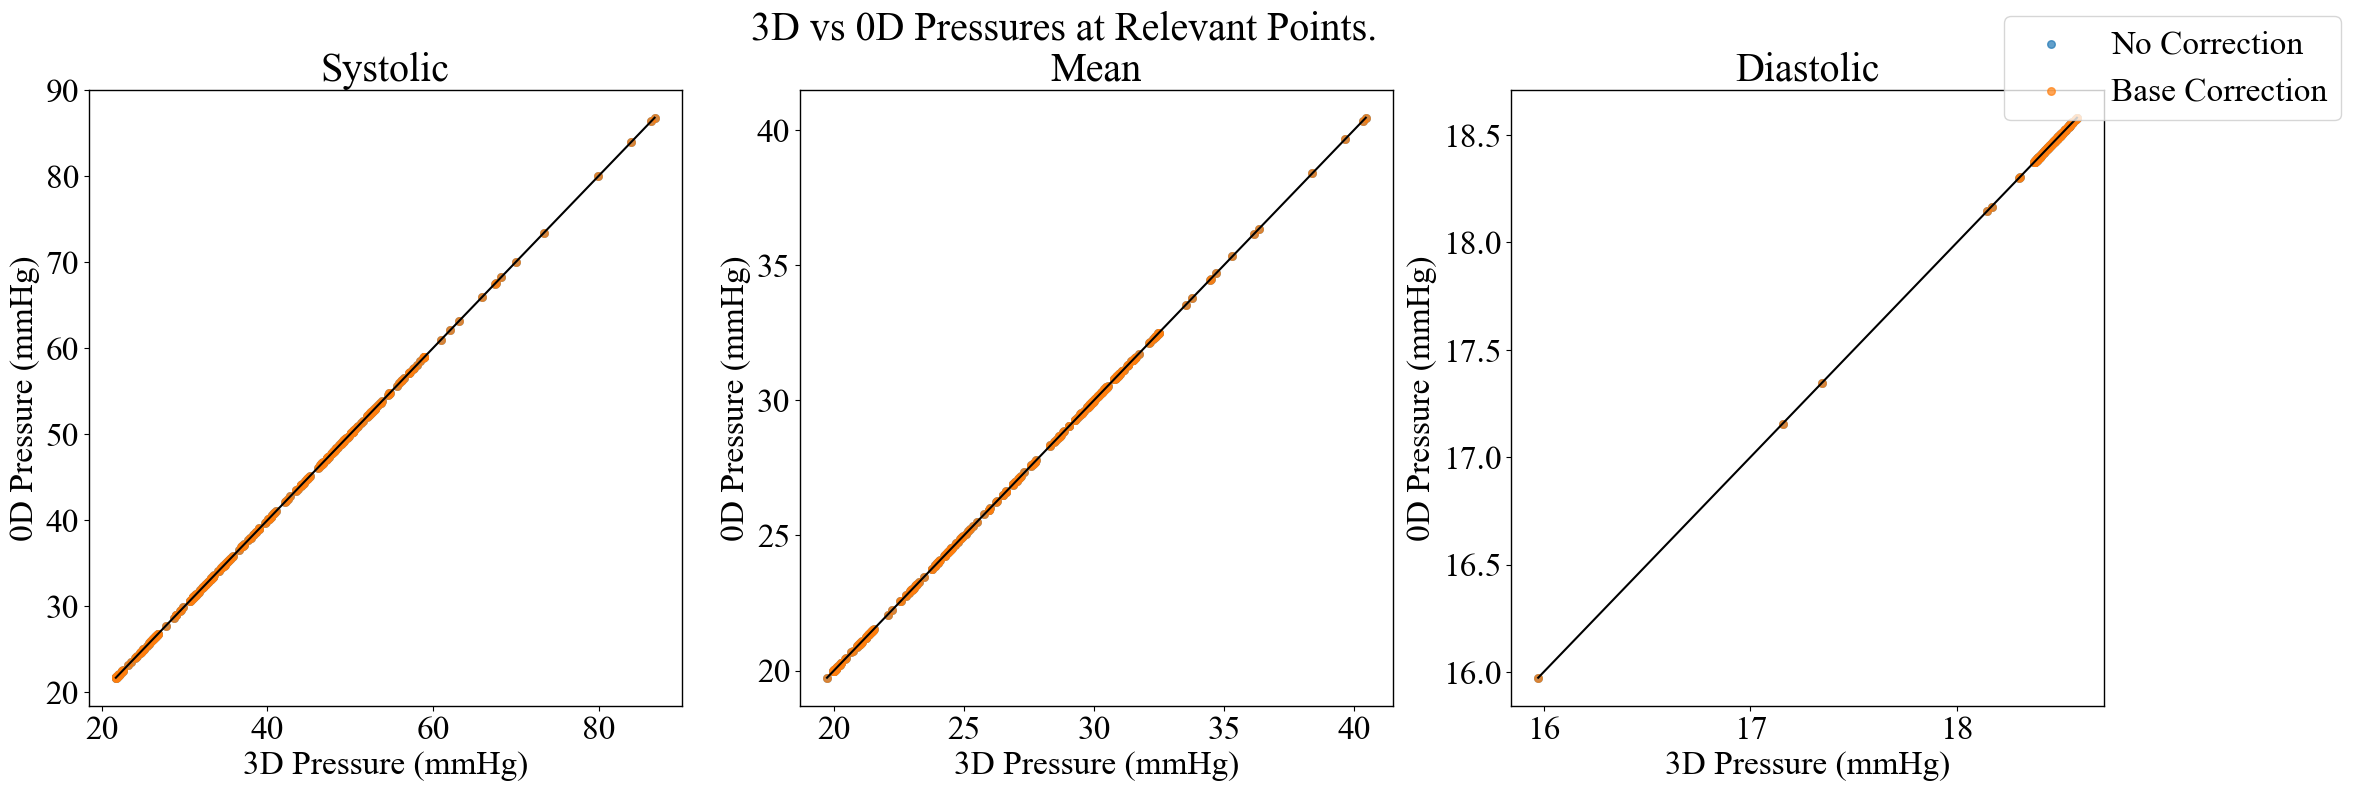

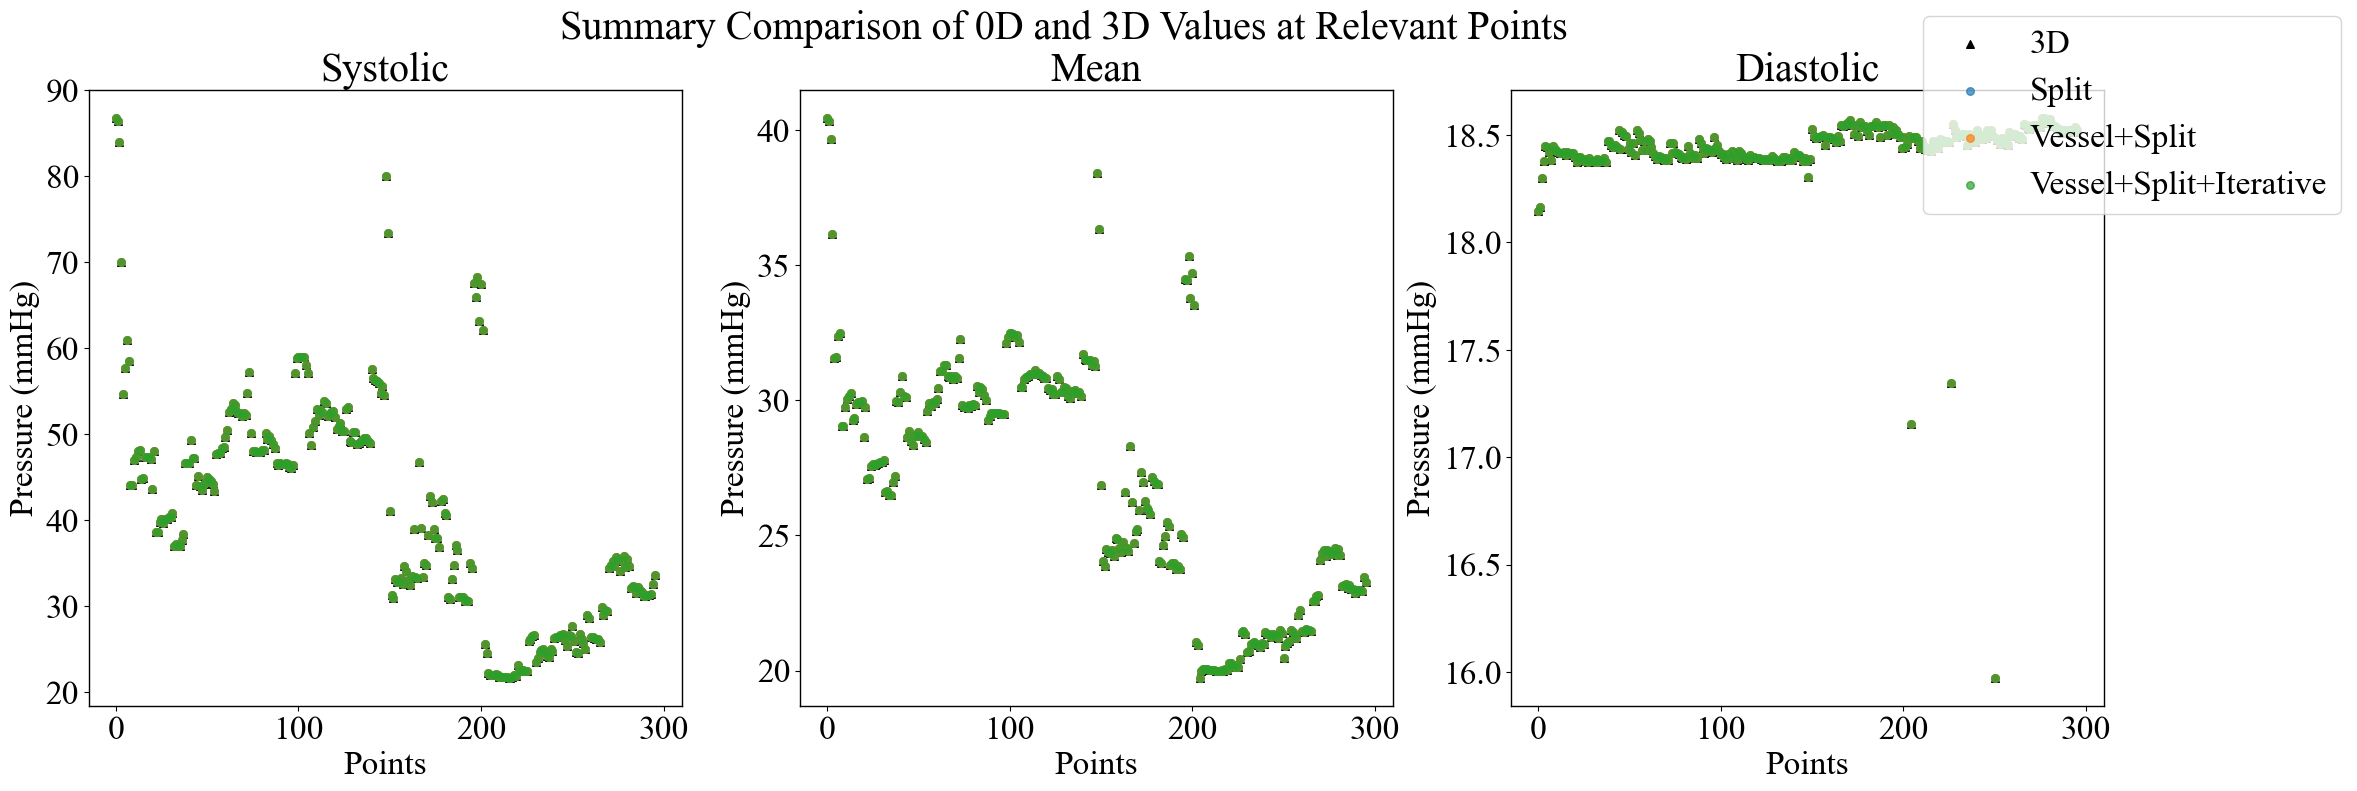

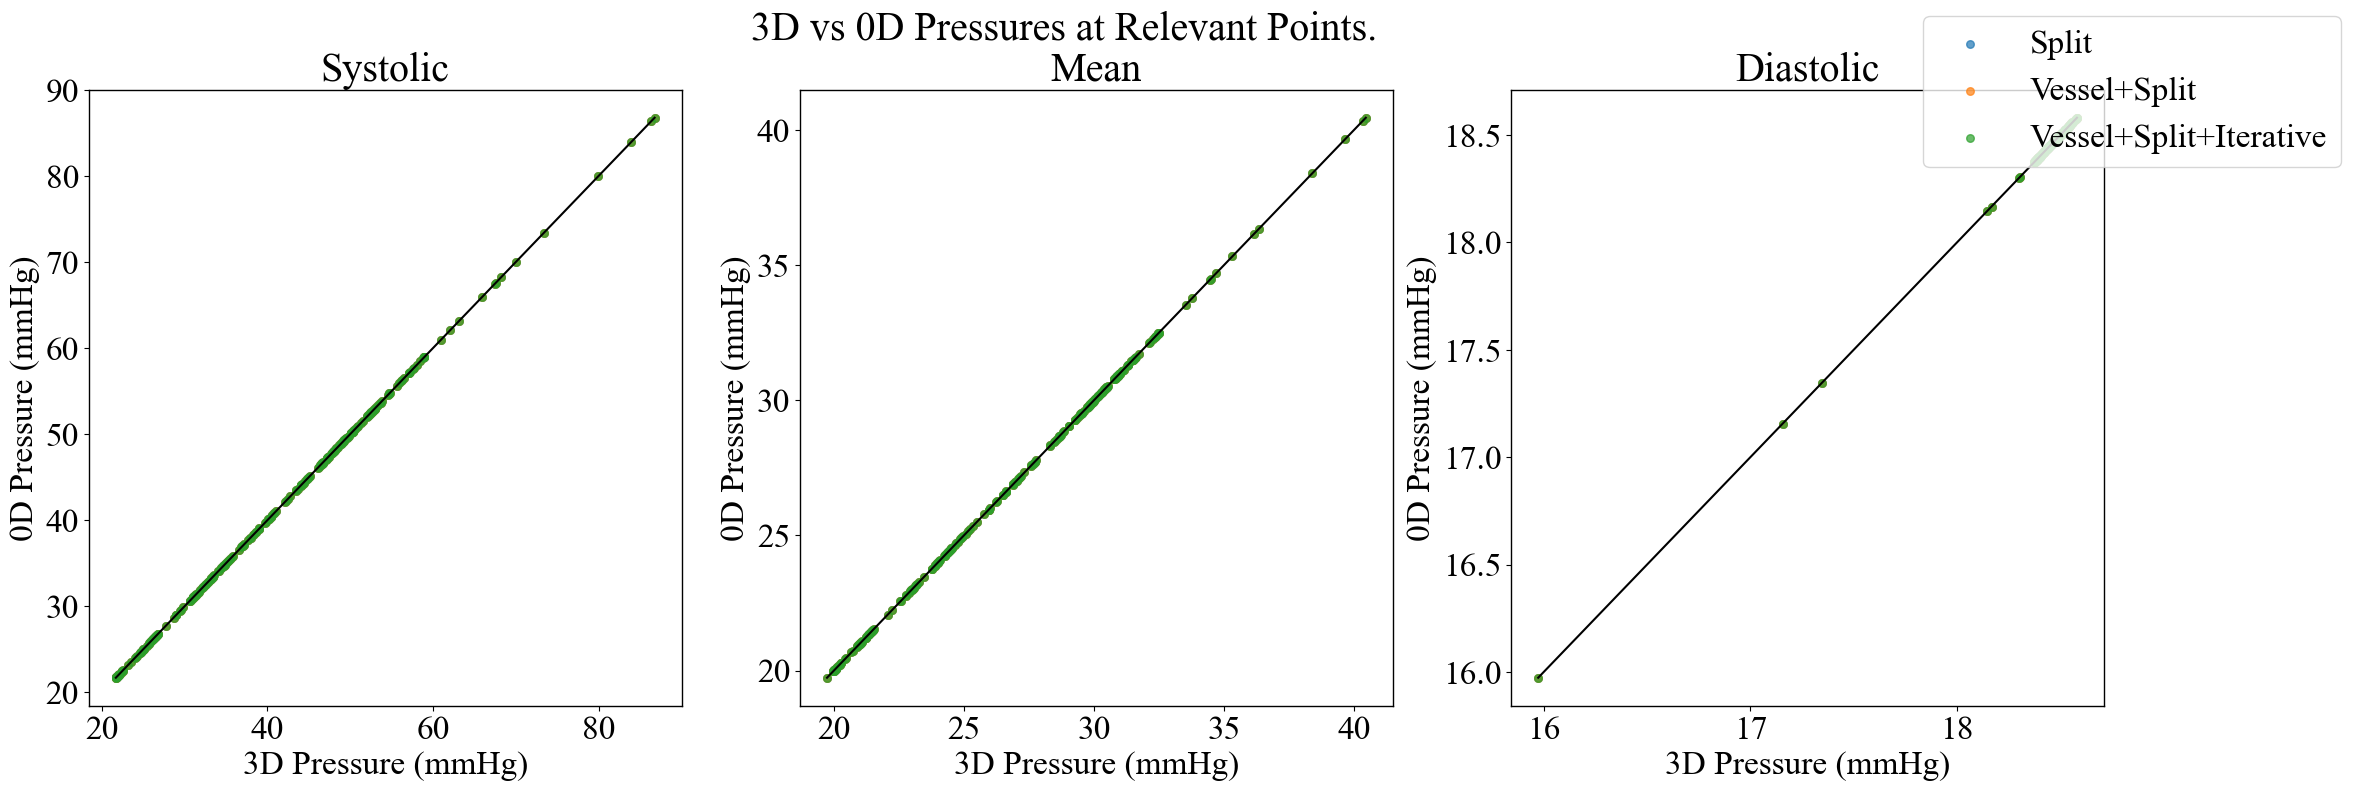

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib


def set_params(font = "Times New Roman", size = 18, linewidth = 1):
    """Converts global parameters

    Args:
        font (str, optional): font. Defaults to "Helvetica Neue".
        size (int, optional): size of font. Defaults to 18.
        linewidth (int, optional): width of axes lines. Defaults to 2.
    """
    # Edit the font, font size, and axes width
    matplotlib.rcParams['font.family'] = font
    plt.rcParams['font.size'] = size
    plt.rcParams['axes.linewidth'] = linewidth
    

def plot_valid2(threed_data, zerod_data):
    
    results_3d = np.load(threed_data, allow_pickle=True).item()
    print(results_3d)
    threed_mins = results_3d['3d_mins']
    threed_maxs = results_3d['3d_maxs']
    threed_means = results_3d['3d_means']
    
    
    fig1, ax1 = plt.subplots(1, 3, figsize=(26, 8), )
    fig2, ax2 = plt.subplots(1, 3, figsize=(26, 8))
    fig1.suptitle("Summary Comparison of 0D and 3D Values at Relevant Points")
    s = 30
    ax1[1].scatter(range(len(threed_means)), threed_means, s =s, color = "black", marker='^', label = '3D')
    ax1[1].set_title("Mean")
    ax1[1].set_ylabel("Pressure (mmHg)")
    ax1[1].set_xlabel("Points")
    
    ax1[0].scatter(range(len(threed_maxs)), threed_maxs, s =s,color = "black", marker='^',label = '3D')
    ax1[0].set_title("Systolic")
    ax1[0].set_ylabel("Pressure (mmHg)")
    ax1[0].set_xlabel("Points")
    
    
    ax1[2].scatter(range(len(threed_mins)), threed_mins,s =s,color = "black", marker='^', label = '3d')
    ax1[2].set_title("Diastolic")
    ax1[2].set_ylabel("Pressure (mmHg)")
    ax1[2].set_xlabel("Points")

    
    fig2.suptitle("3D vs 0D Pressures at Relevant Points.")
    ax2[0].plot([min(threed_maxs), max(threed_maxs)], [min(threed_maxs), max(threed_maxs)], 'black')
    ax2[0].set_title("Systolic")
    ax2[1].plot([min(threed_means), max(threed_means)], [min(threed_means), max(threed_means)], 'black')
    ax2[1].set_title("Mean")
    ax2[2].plot([min(threed_mins), max(threed_mins)], [min(threed_mins), max(threed_mins)], 'black')
    ax2[2].set_title("Diastolic")
    for i in range(3):
        ax2[i].set_ylabel("0D Pressure (mmHg)")
        ax2[i].set_xlabel("3D Pressure (mmHg)")
    

    zerod = np.load(zerod_data, allow_pickle=True).item()
    
    for name, results_0d in zerod.items():
        zerod_mins = results_0d['0d_mins']
        zerod_maxs = results_0d['0d_maxs']
        zerod_means = results_0d['0d_means']
        ## Summary Statistics
        
        ## means
        ax1[1].scatter(range(len(zerod_means)), zerod_means,s =s, label = name, alpha = .7)
        
        ## systolic
        ax1[0].scatter(range(len(zerod_maxs)), zerod_maxs, s =s,label = name, alpha = .7)
        
        # diastolic
        ax1[2].scatter(range(len(zerod_mins)), zerod_mins,s =s, label = name, alpha = .7)
        
        ## plot 3D on x axis, and 0D on y axis
        ax2[0].scatter(threed_maxs, zerod_maxs,s =s, label = name, alpha = .7)
        ax2[1].scatter(threed_means, zerod_means,s =s, label = name, alpha = .7)
        ax2[2].scatter(threed_mins, zerod_mins, s =s,label = name, alpha = .7)

        


    handles, labels = ax1[0].get_legend_handles_labels()
    fig1.legend(handles, labels, loc='upper right')
    handles, labels = ax2[0].get_legend_handles_labels()
    fig2.legend(handles, labels, loc='upper right')
    
    return fig1, fig2

set_params(size=24)
fig1, fig2 = plot_valid2('3d_data_f6.npy', '0d_data_f6.npy')
fig3, fig4 = plot_valid2('3d_data_f7.npy', '0d_data_f7.npy')